In [ ]:
!pip install --upgrade tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 44.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [1]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset.git


Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163235, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 163235 (delta 2), reused 0 (delta 0), pack-reused 163229 (from 1)
Receiving objects: 100% (163235/163235), 2.00 GiB | 23.35 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Updating files: 100% (182401/182401), done.


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
def load_image(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        return img
    except (UnidentifiedImageError, OSError):
        print(f"Error: {img_path}")
        return Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8), 'RGB')


In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=15
dataset_path = "/content/PlantVillage-Dataset/raw/data"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3171 files belonging to 4 classes.


In [7]:
class_names = dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[3 0 0 1 1 0 3 3 0 3 3 3 3 1 2 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0]


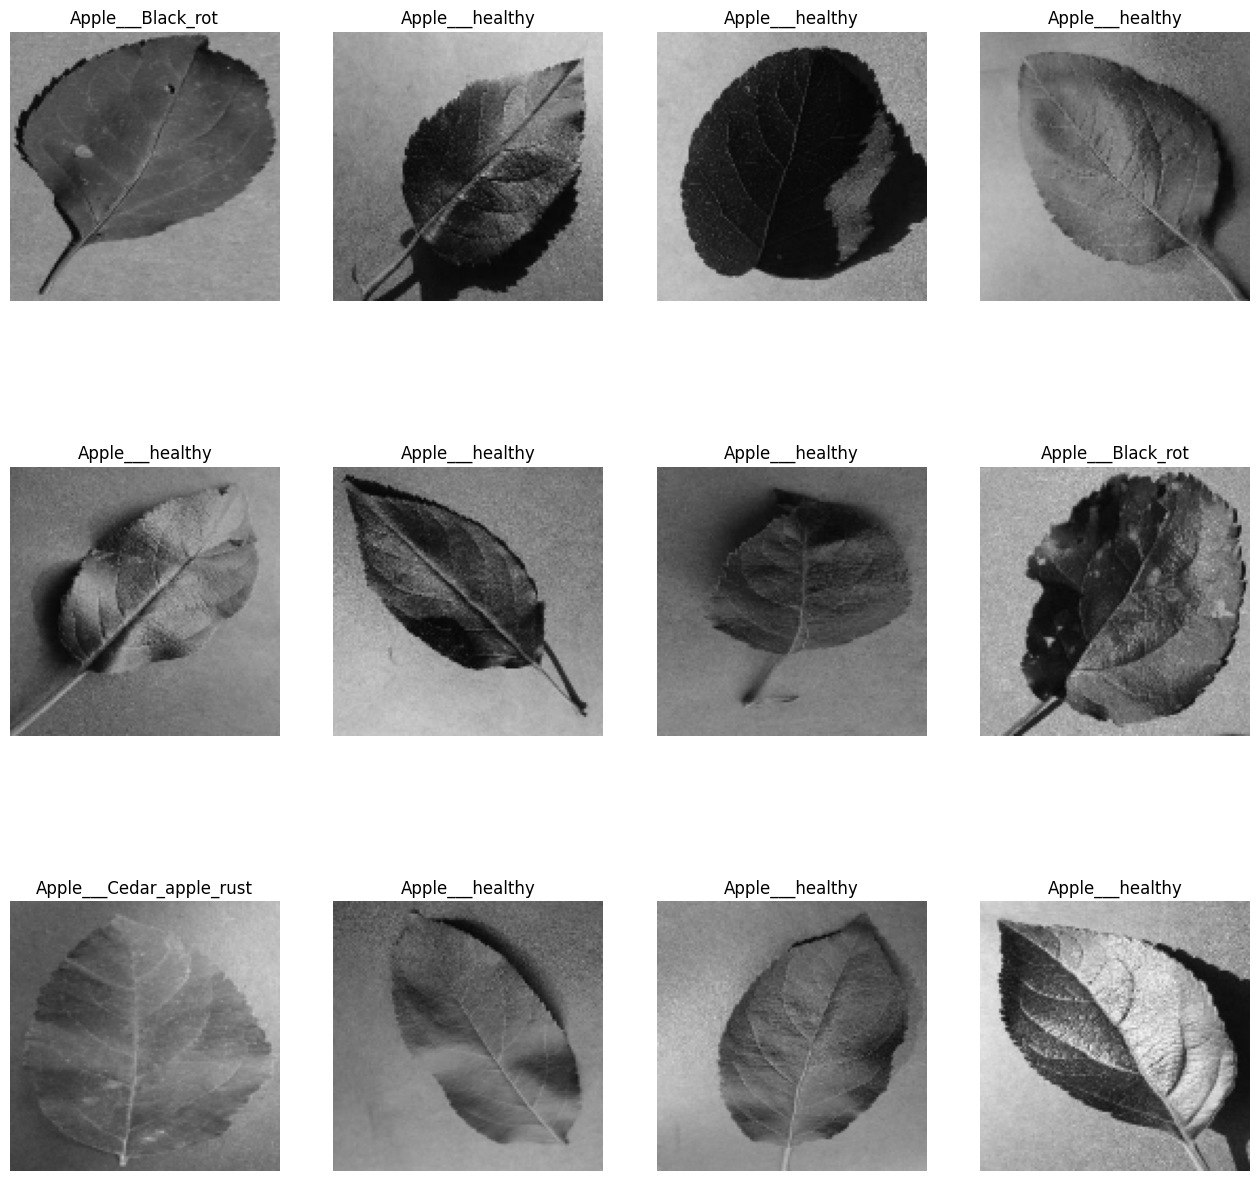

In [9]:
plt.figure(figsize=(16, 16))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
len(dataset)
train_size = 0.8
len(dataset)*train_size

80.0

In [12]:
train_ds = dataset.take(80)
len(train_ds)

80

In [13]:
test_ds = dataset.skip(80)
len(test_ds)

20

In [14]:
val_size=0.1
len(dataset)*val_size

10.0

In [15]:
val_ds = test_ds.take(10)
len(val_ds)

10

In [16]:
test_ds = test_ds.skip(10)
len(test_ds)

10

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the model

In [20]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255),
])


In [21]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [25]:
from tensorflow.keras import layers, models

# Define input shape for the model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Exclude batch size here
n_classes = 12

model = models.Sequential([
    layers.Input(shape=input_shape),  # Explicitly define the input shape
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Build and summarize the model
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 241,548 (943.55 KB)

 Trainable params: 241,548 (943.55 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25
)

Epoch 1/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.4835 - loss: 1.4588 - val_accuracy: 0.4880 - val_loss: 1.1846
Epoch 2/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.5237 - loss: 1.1032 - val_accuracy: 0.5052 - val_loss: 1.1143
Epoch 3/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5687 - loss: 1.0185 - val_accuracy: 0.5636 - val_loss: 1.0031
Epoch 4/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.6181 - loss: 0.8955 - val_accuracy: 0.6460 - val_loss: 0.9160
Epoch 5/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6589 - loss: 0.8309 - val_accuracy: 0.6873 - val_loss: 0.8138
Epoch 6/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.6997 - loss: 0.7488 - val_accuracy: 0.6770 - val_loss: 0.8212
Epoch 7/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7156 - loss: 0.7171 - val_accuracy: 0.6770 - val_loss: 0.9071
Epoch 8/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.6933 - loss: 0.7310 - val_accuracy: 0.7320 - val_l

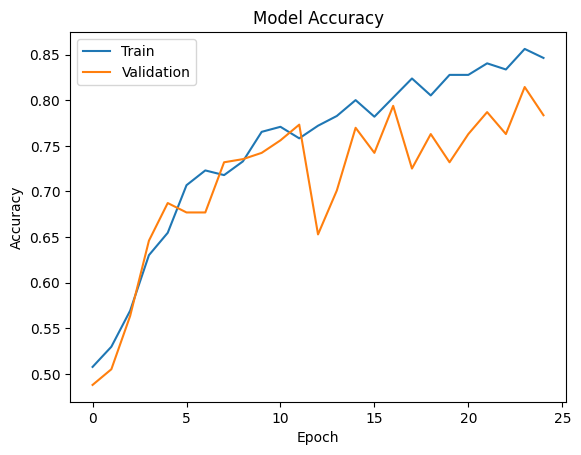

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

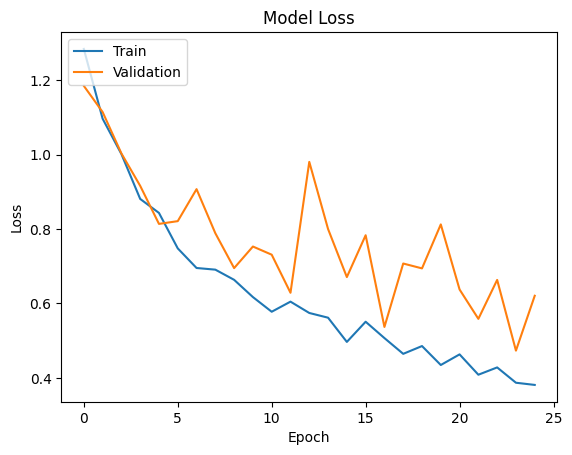

In [29]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [31]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [32]:
model.save('/content/drive/MyDrive/plant_cnn.keras')


In [34]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/plant_cnn.keras')


In [37]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np

# Load the trained model
model_path = '/content/drive/MyDrive/model1.keras'
model = load_model(model_path)

# Class names
CLASS_NAMES = ['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

def preprocess_image(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def predict_class(image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)

    # Make predictions
    predictions = model.predict(img_array)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Get the predicted class label
    predicted_class = CLASS_NAMES[predicted_class_index]

    return predicted_class

# Example usage
image_path = '/content/PlantVillage-Dataset/raw/data/Apple___Cedar_apple_rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655.JPG'
predicted_class = predict_class(image_path)
print(f'Predicted Class: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Predicted Class: Apple___Cedar_apple_rust
